# Nhóm 17

Sinh viên thực hiện: 
STT	Họ tên	            MSSV
1	Kiều Minh Phước	    20521774
2	Nguyễn Thành Long	20521571
3	Lưu Thượng Vỹ	    20522179
4	Trương Minh Phong	20521751
5	Lâm Quốc Đạt	    20520433

## Thêm các thư viện

In [28]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MaxAbsScaler
import numpy as np
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import seaborn as sns

In [29]:
df = pd.read_csv('processed_motors_dataset.csv')

## Phân tích thăm dò

In [30]:
df = df.dropna(subset=['price'])
df = df.dropna(subset=['kilometers_traveled'])
df = df[(df['price'] < 1000000000) & (df['price'] > 1000000)]
df = df.dropna()

In [31]:
import pandas as pd
from scipy.stats import f_oneway

# Giả sử df là DataFrame của bạn

# Lọc các cột phân loại từ DataFrame
categorical_columns = df.select_dtypes(include=['object']).columns

# Tạo một DataFrame mới để lưu kết quả
anova_results = pd.DataFrame(columns=['Column', 'F-statistic', 'P-value'])

# Thực hiện F-test cho từng cột phân loại
for column in categorical_columns:
    unique_values = df[column].unique()
    
    # Loại bỏ các cột phân loại có ít hơn hai giá trị
    if len(unique_values) < 2:
        continue
    
    # Loại bỏ các dòng có giá trị NaN trong cột 'price'
    data = df[[column, 'price']].dropna()

    # Thực hiện F-test
    f_statistic, p_value = f_oneway(*[data[data[column] == category]['price'] for category in unique_values])
    
    # Lưu kết quả vào DataFrame mới
    anova_results = pd.concat([anova_results, pd.DataFrame({
        'Column': [column],
        'F-statistic': [f_statistic],
        'P-value': [p_value]
    })], ignore_index=True)

# Sắp xếp kết quả theo giảm dần của F-statistic
anova_results = anova_results.sort_values(by='F-statistic', ascending=False)
anova_results[anova_results['P-value'] <= 0.05] 
# Lấy tập hợp giá trị có F-statistic cao nhất và p-value <= 0.05
top_categories = anova_results['Column'].tolist()

# Hiển thị kết quả
print(top_categories)
anova_results

['volume', 'type', 'origin', 'automaker', 'series', 'location']


,Column,F-statistic,P-value
3,volume,767.376954,0.000000e+00
2,type,339.344793,8.988311e-145
4,origin,93.915746,3.741328e-189
0,automaker,85.822123,0.000000e+00
1,series,53.157764,0.000000e+00
5,location,3.650019,5.870563e-16


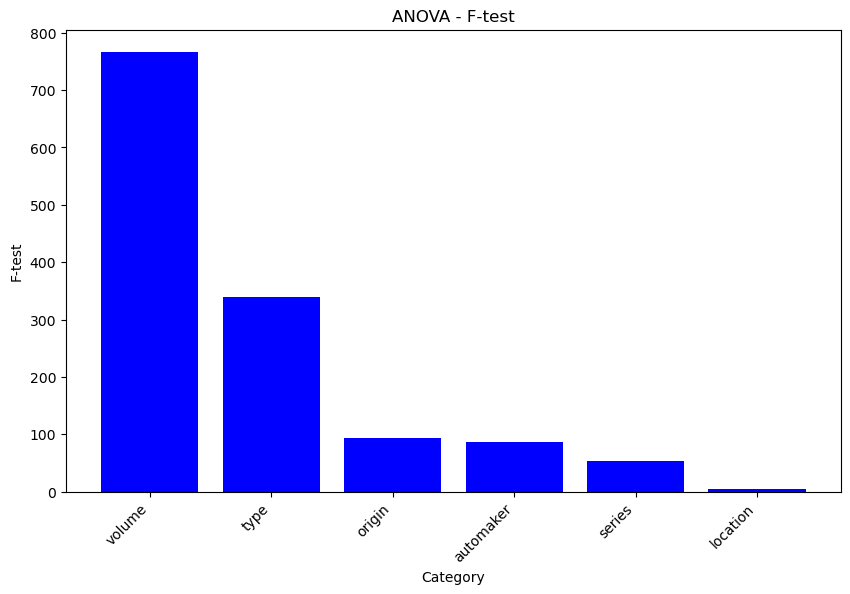

In [32]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ cột cho F-statistic
plt.figure(figsize=(10, 6))
plt.bar(anova_results['Column'], anova_results['F-statistic'], color='blue')
plt.title('ANOVA - F-test')
plt.xlabel('Category')
plt.ylabel('F-test')
plt.xticks(rotation=45, ha='right')
plt.show()



F-test của 'volume', 'type', 'origin', 'automaker', 'series' lớn nên có khả năng ảnh hưởng mạnh tới biến 'price'.
=> 'volume', 'type', 'origin', 'automaker', 'series'

In [33]:
import pandas as pd
import scipy.stats as stats

def find_significant_vars(df: pd.DataFrame, target_var: str, alpha: float = 0.05) -> list:
   
    numeric_vars = df.select_dtypes(include=['float64', 'int64']).columns
   
    numeric_vars = numeric_vars.drop(target_var)
    
    significant_vars = []

    results = pd.DataFrame(columns=['Column', 'F-statistic', 'P-value'])
    
    for var in numeric_vars:
        correlation, p_value = stats.pearsonr(df[var], df[target_var])
        
        if p_value < alpha:

            results = pd.concat([results, pd.DataFrame({
                'Column': [var],
                'F-statistic': [correlation],
                'P-value': [p_value]
            })], ignore_index=True)

    
    return results
find_significant_vars(df, 'price')

,Column,F-statistic,P-value
0,year,0.108871,1.125501e-39
1,kilometers_traveled,-0.060765,2.106098e-13
2,partner,0.118318,1.365301e-46


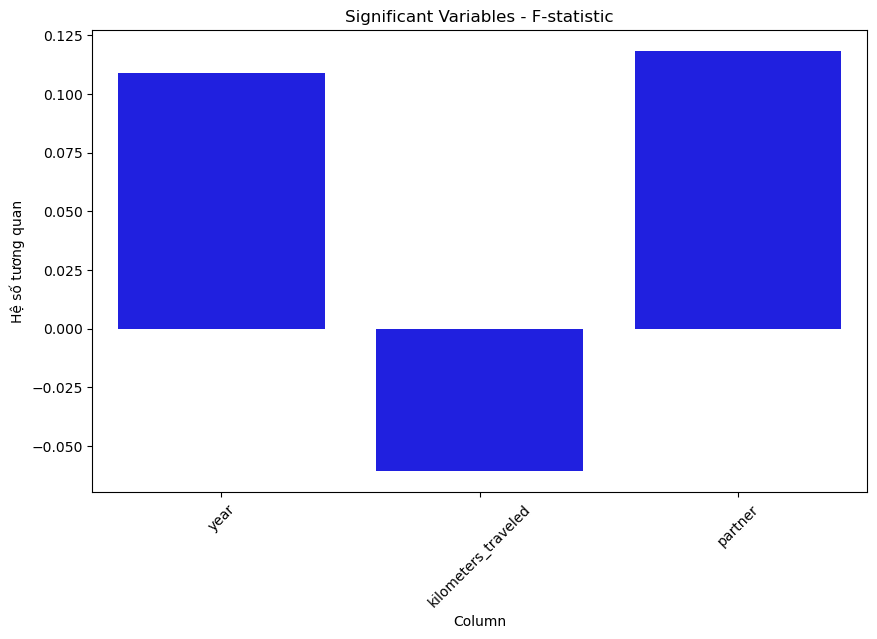

In [34]:
import seaborn as sns
significant_variables = find_significant_vars(df, 'price')

# Plot the results
plt.figure(figsize=(10, 6))
sns.barplot(x='Column', y='F-statistic', data=significant_variables,color='blue')
plt.title('Significant Variables - F-statistic')
plt.ylabel('Hệ số tương quan')  
plt.xticks(rotation=45)
plt.show()



Hệ số tương quan của 'year', 'partner' và 'kilometers_traveled' gần về 0 nên không có sự tương quan = > 3 biến này không ảnh hưởng đến 'price'.

## Xây dựng mô hình

In [35]:
df = df.dropna()
df = df[(df['price'] >= 1000000) & (df['price'] <= 200000000)]

In [36]:
# Chọn các đặc trưng và biến mục tiêu
features = ['volume', 'type', 'origin', 'automaker', 'series']
target = 'price'

In [37]:
# Đặc trưng có thể chứa dữ liệu categorical
categorical_features = ['volume', 'type', 'origin', 'automaker', 'series']

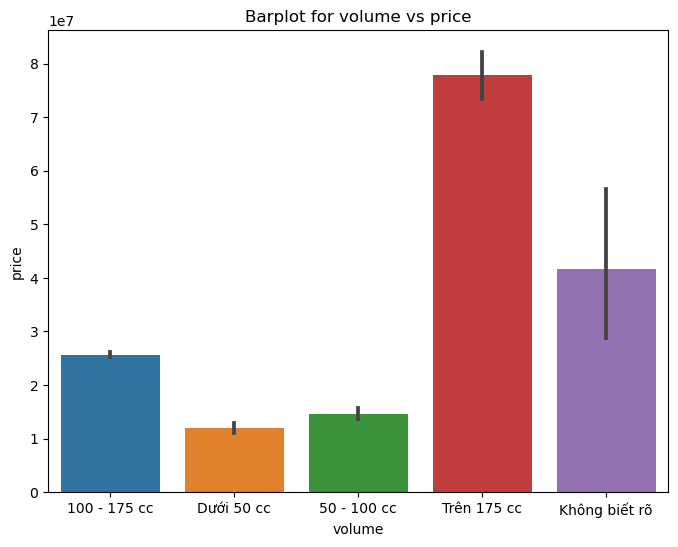

In [38]:
# Biểu đồ Barplot cho biến 'volume'
plt.figure(figsize=(8, 6))
sns.barplot(x='volume', y=target, data=df)
plt.title('Barplot for volume vs ' + target)
plt.show()



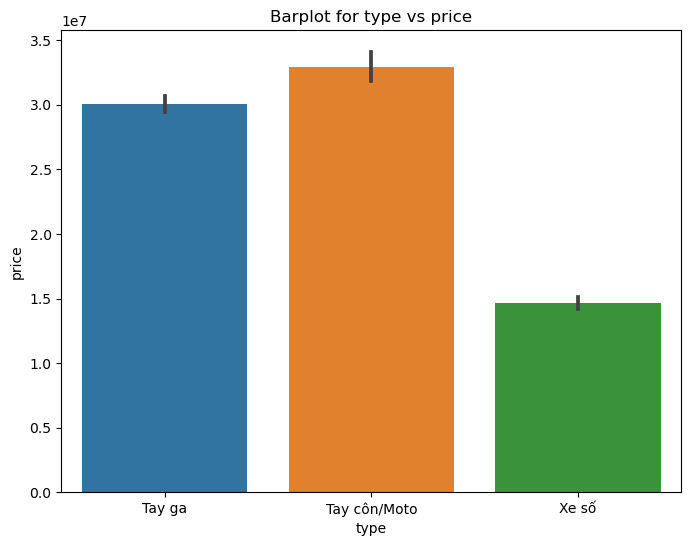

In [39]:
# Biểu đồ Barplot cho biến 'type'
plt.figure(figsize=(8, 6))
sns.barplot(x='type', y=target, data=df)
plt.title('Barplot for type vs ' + target)
plt.show()




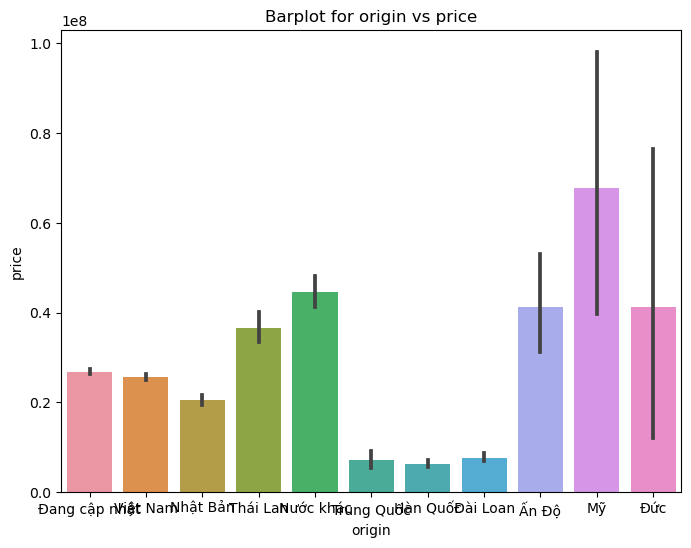

In [40]:
# Biểu đồ Barplot cho biến 'origin'
plt.figure(figsize=(8, 6))
sns.barplot(x='origin', y=target, data=df)
plt.title('Barplot for origin vs ' + target)
plt.show()



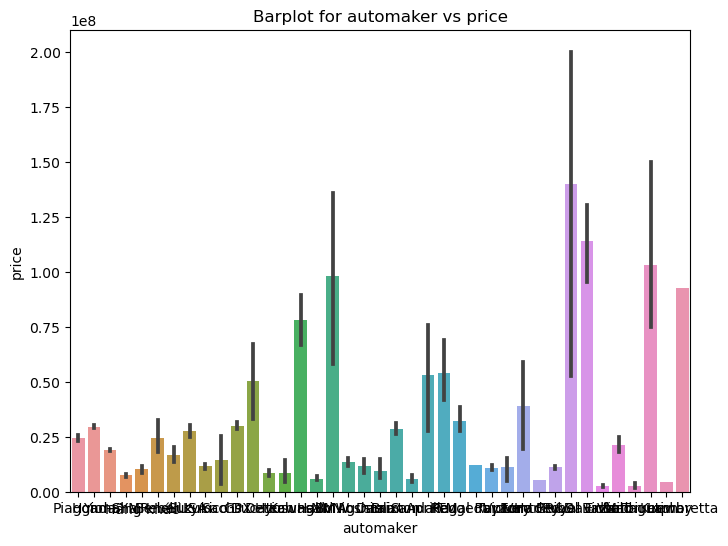

In [41]:
# Biểu đồ Barplot cho biến 'automaker'
plt.figure(figsize=(8, 6))
sns.barplot(x='automaker', y=target, data=df)
plt.title('Barplot for automaker vs ' + target)
plt.show()



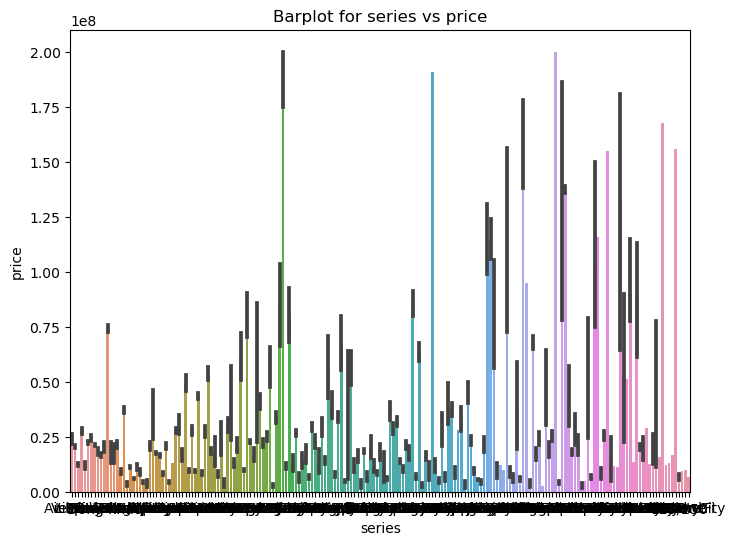

In [42]:
# Biểu đồ Barplot cho biến 'series'
plt.figure(figsize=(8, 6))
sns.barplot(x='series', y=target, data=df)
plt.title('Barplot for series vs ' + target)
plt.show()

In [43]:
# Xây dựng pipeline xử lý dữ liệu
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [44]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ]
)

### Lấy ra tập train và tập test

In [45]:
# Xử lý và chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_processed = preprocessor.fit_transform(df[features])
X_train, X_test, y_train, y_test = train_test_split(X_processed, df[target], test_size=0.1, random_state=42)

X_train, X_test: biến độc lập và phụ thuộc của bộ train

y_train, y_test: biến độc lập và phụ thuộc của bộ test

### Random Forest

In [46]:
# Xây dựng mô hình Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

### Hồi quy tuyến tính đa biến

In [47]:
# Xây dựng mô hình hồi quy tuyến tính
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

### KNN

In [48]:
# Xây dựng mô hình KNN
knn_model = KNeighborsRegressor(n_neighbors=5)  # Số lượng láng giềng cần xem xét (ở đây là 5)
knn_model.fit(X_train, y_train)

KNeighborsRegressor()

### Decision Tree

In [49]:
# Xây dựng mô hình cây quyết định
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

### Kết quả dự đoán của Mô hình

In [50]:
# Dự đoán trên tập kiểm tra
y_pred_rf = rf_model.predict(X_test)
y_pred_lr = lr_model.predict(X_test)
y_pred_knn = knn_model.predict(X_test)
y_pred_dt = dt_model.predict(X_test)

In [51]:
y_pred_lr

array([32365362.06424614, 15210981.28366206, 63654412.21737284, ...,
       17396973.82713863, 24877501.02215628, 21472890.61092553])

## Đánh giá mô hình

### Các thang đo

#### Dictionary về các model và giá trị dự đoán của chúng

In [52]:
# Đưa các mô hình và kết quả dự đoán của chúng vào trong một dictionary
d = {
     'Random Forest': y_pred_rf, 
     'Linear Regression': y_pred_lr, 
     'KNN': y_pred_knn, 
     'Decision Tree': y_pred_dt
}

In [53]:
# Hàm tính kết quả các thang đo
def ketQuaCacThangDo(models, dataTest, dataTrain, X_test):
    results = []
    n = len(dataTest)  # Số lượng mẫu
    p = X_test.shape[1]  # Số lượng features
    
    for model, dataPred in models.items():
        data_train_mean = dataTrain.mean()
        
        mae = mean_absolute_error(dataTest, dataPred)
        medae = median_absolute_error(dataTest, dataPred)
        rae = mae / mean_absolute_error(dataTest, [data_train_mean] * len(dataTest))
        rmse = np.sqrt(mean_squared_error(dataTest, dataPred))
        r2 = r2_score(dataTest, dataPred)
        adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    

        results.append({
            'Model': model,
            'MAE': f'{mae:.8f}',
            'RAE': f'{rae:.16f}',
            'RMSE': f'{rmse:.8f}',
            'R²': f'{r2:.8f}',
            'Adjusted R²': f'{adjusted_r2:.8f}'
        })
    
    return pd.DataFrame(results)

In [54]:
ketQuaCacThangDo(d, y_test, y_train, X_test)

,Model,MAE,RAE,RMSE,R²,Adjusted R²
0,Random Forest,8343393.56660707,0.4892376645175727,14252691.26677800,0.68404826,0.61788175
1,Linear Regression,8751816.86037372,0.5131866796013985,14902487.17672485,0.65458237,0.58224512
2,KNN,8963439.57220292,0.5255957551733060,15046066.16374557,0.64789441,0.57415656
3,Decision Tree,8373770.18278930,0.4910188803547855,14453531.94418711,0.67508111,0.60703670


### Đánh giá trực quan mô hình

#### Scatter plots

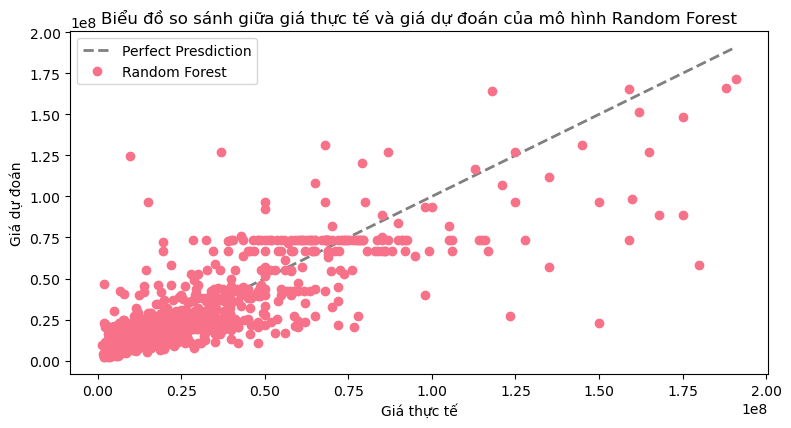

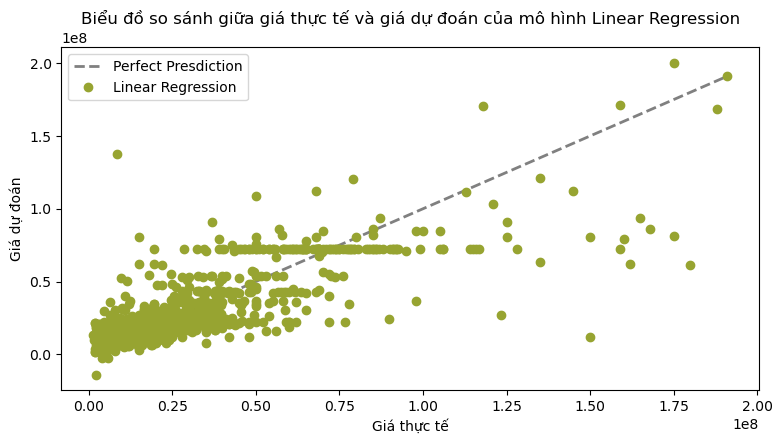

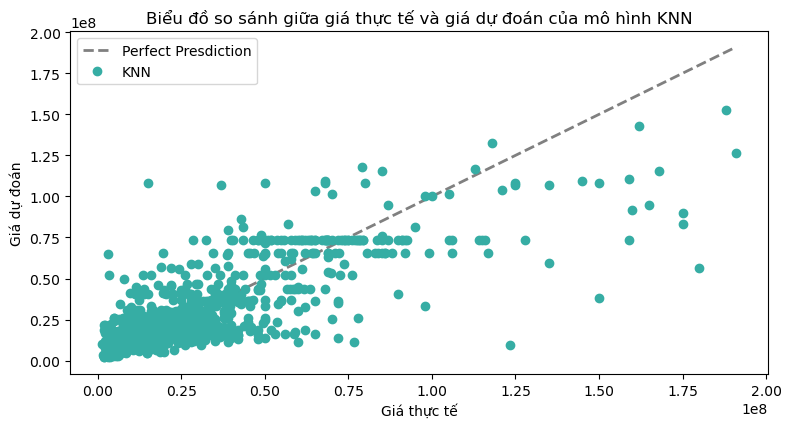

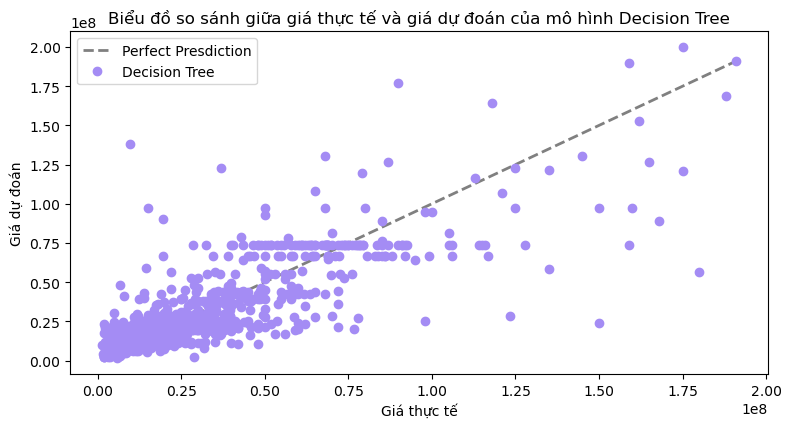

In [55]:
from matplotlib import pyplot as plt

# Tạo dãy số từ giá trị nhỏ nhất đến lớn nhất của y_test
x_range = np.linspace(min(y_test), max(y_test), 100)

# Tạo danh sách màu ngẫu nhiên theo số lượng model
palette = sns.color_palette("husl", n_colors=len(d))

for i, (model, dataPred) in enumerate(d.items()):
    plt.figure(figsize=(9, 4.45))
    plt.plot(x_range, x_range, linestyle='--', color='gray', linewidth=2, label='Perfect Presdiction')
    
    color = palette[i]
    plt.plot(y_test, dataPred, 'o', color=color, label=f'{model}')

    plt.title(f'Biểu đồ so sánh giữa giá thực tế và giá dự đoán của mô hình {model}')
    plt.xlabel('Giá thực tế')
    plt.ylabel('Giá dự đoán')
    plt.legend()
    plt.show()

#### KDE (Kernel Density Estimate) plot

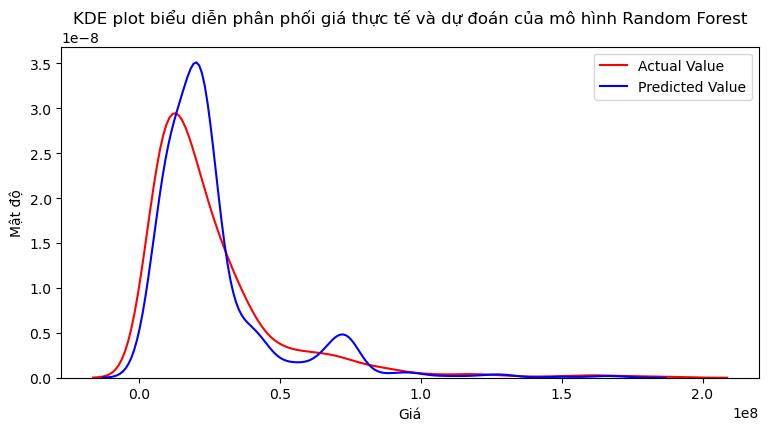

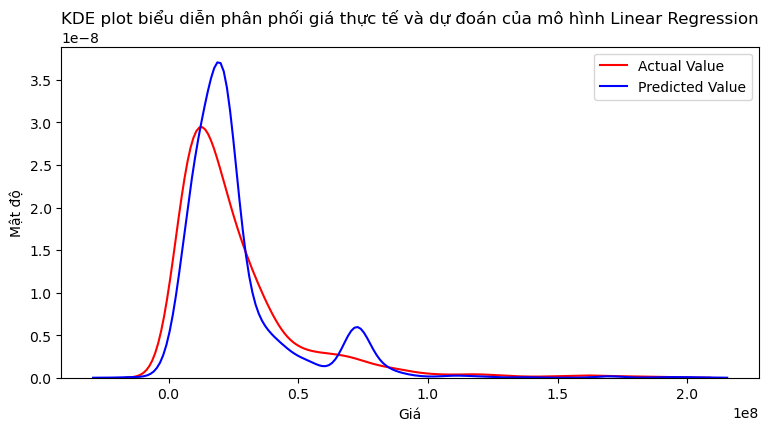

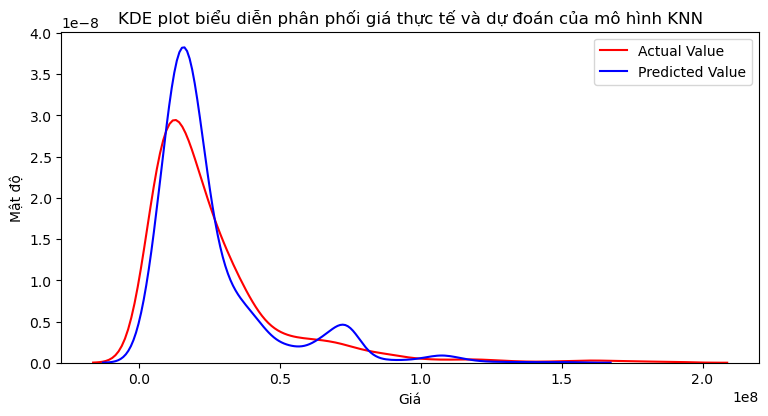

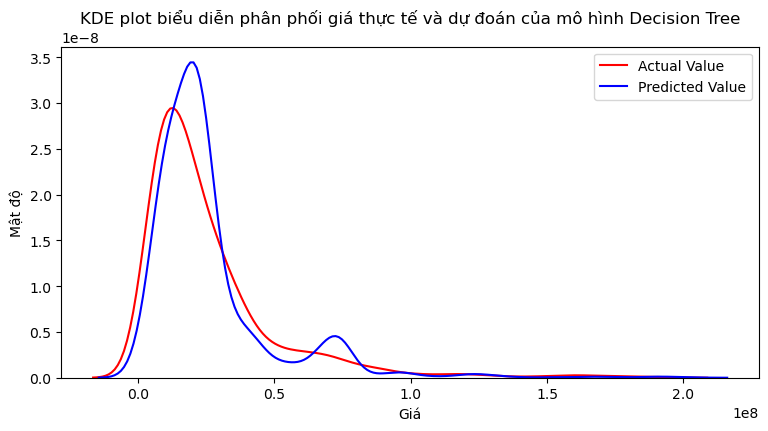

In [56]:
for model, dataPred in d.items():
    fig, ax1 = plt.subplots(figsize=(9, 4.3))

    ax1 = sns.kdeplot(y_test, fill=False, color='r', label="Actual Value")

    sns.kdeplot(dataPred, fill=False, color='b', label="Predicted Value", ax=ax1)
    
    ax1.set_title(f"KDE plot biểu diễn phân phối giá thực tế và dự đoán của mô hình {model}")
    
    plt.xlabel('Giá')
    plt.ylabel('Mật độ')
    plt.legend()
    plt.show()

#### Residual plot

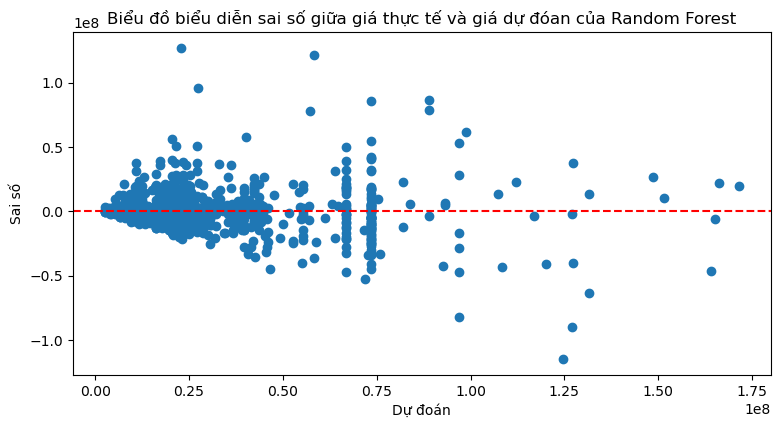

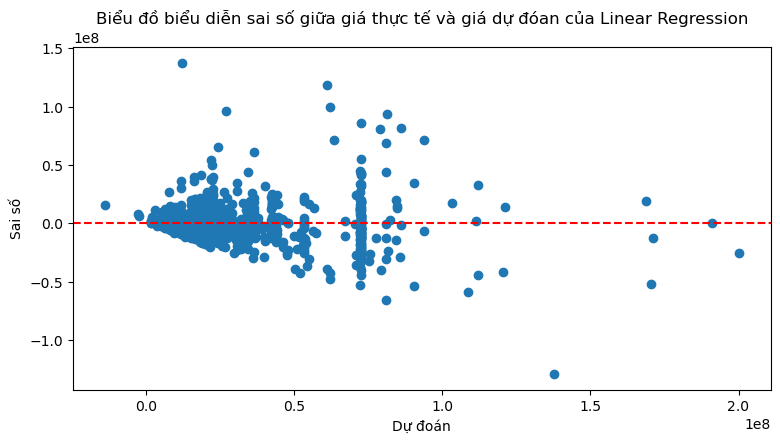

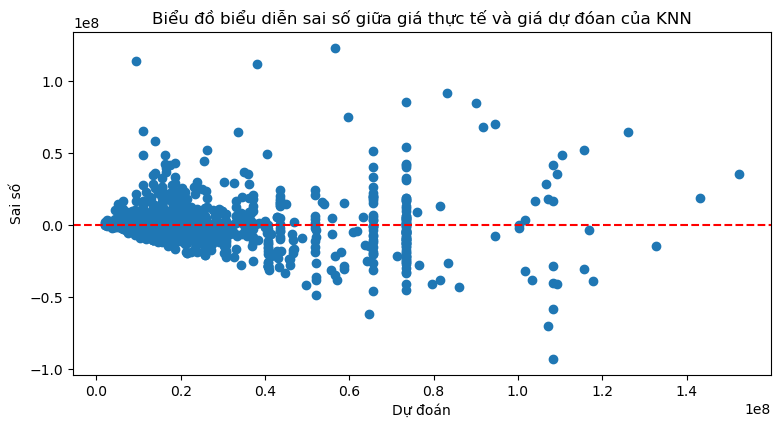

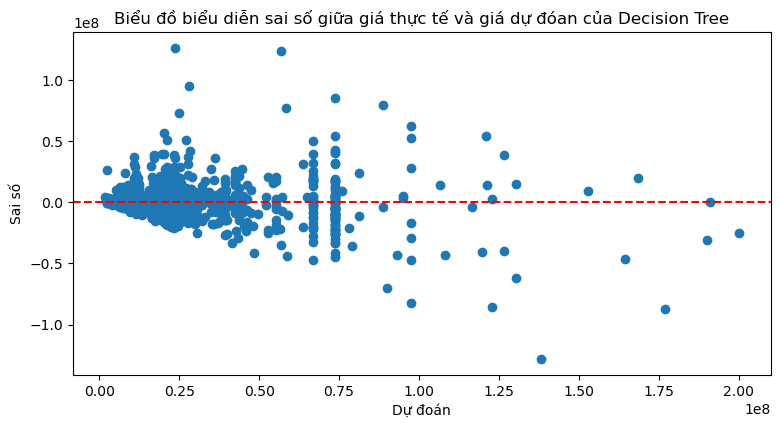

In [57]:
for model, dataPred in d.items():
    plt.figure(figsize=(9, 4.45))
    
    residuals = y_test - dataPred
    
    plt.scatter(dataPred, residuals)
    
    plt.xlabel("Dự đoán")
    plt.ylabel("Sai số")
    plt.title(f"Biểu đồ biểu diễn sai số giữa giá thực tế và giá dự đóan của {model}")
    plt.axhline(y=0, color='r', linestyle='--')
    
    plt.show()